In [1]:
import numpy as np
import scipy.io as spio
import matplotlib.pyplot as plt
import os
import gdown
import zipfile
import scipy as sp
from reservoirpy.nodes import Input, Reservoir, Ridge
from reservoirpy.observables import mse
import pickle
from sklearn.metrics import cohen_kappa_score

In [2]:
data_path = "data/processed/"
data_labels = ["inputs", "ph_targets", "wd_targets", "pos_targets", "srl_targets"]
dataset = {}
for dl in data_labels:
    with open(data_path+dl+'.pkl', 'rb') as fp:
        data = pickle.load(fp)
    dataset.update({dl: data})


In [3]:
train, test = int(0.7 * len(dataset['inputs'])), int(0.3 * len(dataset['inputs']))

train_data = dataset['inputs'][:train]
train_target1 = dataset["ph_targets"][:train]
train_target2 = dataset["wd_targets"][:train]
train_target3 = dataset["pos_targets"][:train]
#train_target4 = dataset["srl_targets"][:train]


test_data = dataset['inputs'][train:]
test_target1 = dataset["ph_targets"][train:]
test_target2 = dataset["wd_targets"][train:]
test_target3 = dataset["pos_targets"][train:]
#test_target4 = dataset["srl_targets"][train:]

In [13]:
def define_network(lr):
    # System parameters
    n_in1 = train_data[0].shape[1]
    n_out1 = train_target1[0].shape[0]
    n_in2 = n_out1
    n_out2 = train_target2[0].shape[0]
    n_in3 = n_out2
    n_out3 = train_target3[0].shape[0]
    # n_in4 = n_out3
    # ...

    n_layers = 3
    N = 100
    n_inputs = [n_in1, n_in2, n_in3]

    leakage_rates = [0.2961,lr,lr]
    spectral_radius = [0.8616, 1.1786, 1.2298]
    input_scaling = [0.7721, 8.8463, 2.6722]
    regularization_terms = [6.56e-3, 4.59e-5, 1.49e-5]
    rec_density = 0.01


    layers = []
    readouts = []
    sub_systems = []

    for layer in range(n_layers):
        Win = np.random.rand(N, n_inputs[layer]+1) - 0.5

        W = np.random.rand(N, N) - 0.5
        mask = np.random.rand(N, N)
        W[mask > rec_density] = 0

        Win = (Win / np.linalg.norm(Win, 2)) * input_scaling[layer]
        original_spectral_radius = np.max(np.real(np.linalg.eigvals(W)))
        W *= (spectral_radius[layer] / original_spectral_radius)
        W = sp.sparse.csr_matrix(W)

        inputs = Input(n_inputs[layer])
        reservoir = Reservoir(N, lr=leakage_rates[layer], sr=spectral_radius[layer], input_bias=True,
                                  input_scaling=input_scaling[layer], W=W, Win=Win)
        readout = Ridge(ridge=regularization_terms[layer])

        system = inputs >> reservoir >> readout
        layers.append(reservoir)
        readouts.append(readout)
        sub_systems.append(system)
        
    return sub_systems

In [5]:
def train_network_0(sub_systems):
    t_t1 = [x.T for x in train_target1[:-1]]
    
    sub_systems[0].fit(train_data, t_t1)

In [6]:
def train_network_1(sub_systems):
    t_t1 = [x.T for x in train_target1[:-1]]
    t_t2 = [x.T for x in train_target2[:-1]]

    sub_systems[1].fit(t_t1, t_t2)

In [7]:
def train_network_2(sub_systems):
    t_t2 = [x.T for x in train_target2[:-1]]
    t_t3 = [x.T for x in train_target3[:-1]]

    sub_systems[2].fit(t_t2, t_t3)

In [8]:
def calculate_accuracy(sub_systems, cur_layer):
    predictions = []
    mse_total = 0
    kappa_total = 0
    
    if cur_layer == 0:
        test_target = test_target1
        t_data = test_data
    elif cur_layer == 1:
        test_target = test_target2
        t_data = test_target1
    else:
        test_target = test_target3
        t_data = test_target2

    for i in range(len(t_data)):
        if cur_layer == 0:
            pred = sub_systems[cur_layer].run(t_data[i])
        else:
            pred = sub_systems[cur_layer].run(t_data[i].T)
        predictions.append(pred)
    for i in range (len(predictions)):
        mse_total += mse(predictions[i], test_target[i].T)
        labels_target = np.argmax(test_target[i], axis=1)
        labels_predicted = np.argmax(predictions[i], axis=0)
        kappa_total += cohen_kappa_score(labels_target, labels_predicted)
    return mse_total, kappa_total

In [ ]:
# mse_results_0 = []
# kappa_results_0 = []
# mse_results_1 = []
# kappa_results_1 = []
# mse_results_2 = []
# kappa_results_2 = []

lr = 0

for i in range (10):
    lr += 0.1
    sub_systems = define_network(lr)

    train_network_0(sub_systems)
    train_network_1(sub_systems)
    train_network_2(sub_systems)

    results_0 = calculate_accuracy(sub_systems, 0)
    mse_results_0.append(results_0[0])
    kappa_results_0.append(results_0[1])

    results_1 = calculate_accuracy(sub_systems, 1)
    mse_results_1.append(results_1[0])
    kappa_results_1.append(results_1[1])

    results_2 = calculate_accuracy(sub_systems, 2)
    mse_results_2.append(results_2[0])
    kappa_results_2.append(results_2[1])

print(mse_results_0, mse_results_1, mse_results_2)
print(kappa_results_0, kappa_results_1, kappa_results_2)


In [22]:
backup_mse_0 = [29.847918755600322, 29.471194283160035, 29.403867270701216, 29.455119845771346, 29.817722952089273, 30.00014778345211, 30.36795787565904, 30.60323281592184, 30.65200310092592, 30.929330455964]
backup_mse_1 = [14.624972852821856, 14.748817328958864, 14.471113756502581, 14.193631771705797, 14.040390416238614, 14.243339542298492, 14.68280112905294, 14.776546756735306, 15.11463305453429, 15.216593703893459]
backup_mse_2 = [51.10444771504214, 48.21306461302944, 47.12298710812515, 46.26917377011922, 46.72417705873353, 46.72973021175513, 49.082824115038505, 45.537470940116386, 45.660516556948615, 45.9265874423489]

backup_kappa_0 = [17.714786080463387, 18.492724484100417, 24.662987447868304, 25.096605060836996, 23.396988640084842, 26.55248620350074, 24.687304365737024, 25.272759228825322, 26.033925065329278, 26.434799117362783]
backup_kappa_1 = [2.3610711241246807, 0.9138962393394794, 0.9244545714260473, 0.8974802345100852, 1.0893125067503464, 0.3351331671497155, 0.1443538897590102, 1.2614689750620964, 2.4630371972393377, 13.07960690963439]
backup_kappa_2 = [6.204186901945521, 1.656751535915758, -1.7296710519763465, -9.56205145172557, -3.181221490026454, 5.392401019662218, 0.4608542779577509, 36.0998425572179, 68.08842932454338, 137.16042146658302]

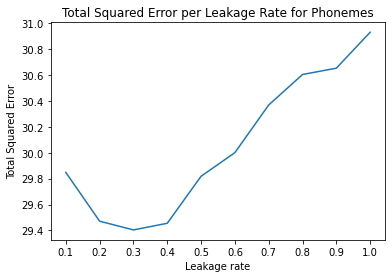

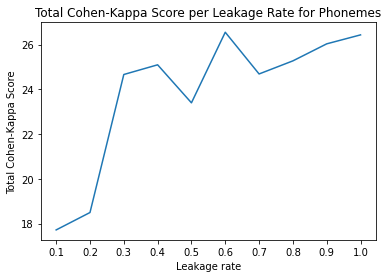

In [28]:
lr_values = []
lr_value = 0
for i in range (10):
    lr_value += 0.1
    lr_values.append(lr_value)


plt.plot(lr_values, backup_mse_0)
plt.title("Total Squared Error per Leakage Rate for Phonemes")
plt.xlabel("Leakage rate")
plt.ylabel("Total Squared Error")
plt.xticks(lr_values)
plt.show()

plt.plot(lr_values, backup_kappa_0)
plt.title("Total Cohen-Kappa Score per Leakage Rate for Phonemes")
plt.xlabel("Leakage rate")
plt.ylabel("Total Cohen-Kappa Score")
plt.xticks(lr_values)
plt.show()

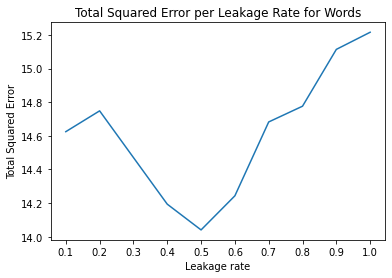

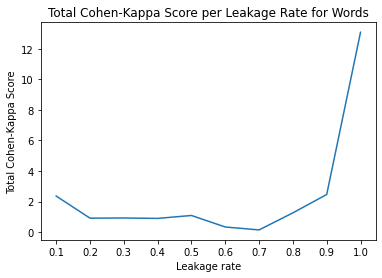

In [29]:
plt.plot(lr_values, backup_mse_1)
plt.title("Total Squared Error per Leakage Rate for Words")
plt.xlabel("Leakage rate")
plt.ylabel("Total Squared Error")
plt.xticks(lr_values)
plt.show()

plt.plot(lr_values, backup_kappa_1)
plt.title("Total Cohen-Kappa Score per Leakage Rate for Words")
plt.xlabel("Leakage rate")
plt.ylabel("Total Cohen-Kappa Score")
plt.xticks(lr_values)
plt.show()

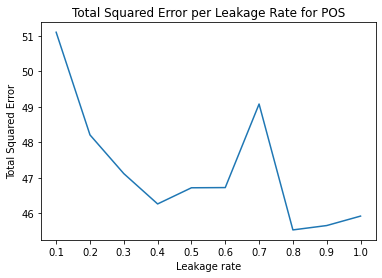

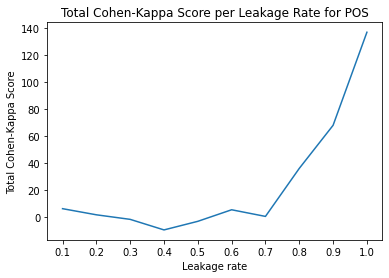

In [30]:
plt.plot(lr_values, backup_mse_2)
plt.title("Total Squared Error per Leakage Rate for POS")
plt.xlabel("Leakage rate")
plt.ylabel("Total Squared Error")
plt.xticks(lr_values)
plt.show()

plt.plot(lr_values, backup_kappa_2)
plt.title("Total Cohen-Kappa Score per Leakage Rate for POS")
plt.xlabel("Leakage rate")
plt.ylabel("Total Cohen-Kappa Score")
plt.xticks(lr_values)
plt.show()

In [ ]:
# new_results_1 = []
# new_kappa_1 = []
# new_mse_1 = []
lr = 0.1
sub_systems = define_network(lr)

train_network_0(sub_systems)
train_network_1(sub_systems)

new_results_1 = calculate_accuracy(sub_systems, 1)
new_mse_1.append(results_1[0])
new_kappa_1.append(results_1[1])


In [ ]:
lr = 0.2
sub_systems_low = define_network(lr)

train_network_0(sub_systems_low)
train_network_1(sub_systems_low)
train_network_2(sub_systems_low)

In [ ]:
lr = 0.5
sub_systems_medium = define_network(lr)

train_network_0(sub_systems_medium)
train_network_1(sub_systems_medium)
train_network_2(sub_systems_medium)

In [ ]:
lr = 0.9
sub_systems_high = define_network(lr)

train_network_0(sub_systems_high)
train_network_1(sub_systems_high)
train_network_2(sub_systems_high)

In [ ]:
lr0 = 0.2961
lr1 = 0.4663
lr2 = 0.6632
sub_systems_opt = define_network(lr0, lr1, lr2)

train_network_0(sub_systems_opt)
train_network_1(sub_systems_opt)
train_network_2(sub_systems_opt)

Running Model-25: 273it [00:00, 3731.10it/s]                                                                           
Running Model-31: 273it [00:00, 3689.33it/s]                                                                           
Running Model-37: 273it [00:00, 3427.24it/s]                                                                           
Running Model-7: 273it [00:00, 3932.05it/s]                                                                            


0.01653997609775283
0.016527174404891154
0.016991361139167153
0.016440686000744716


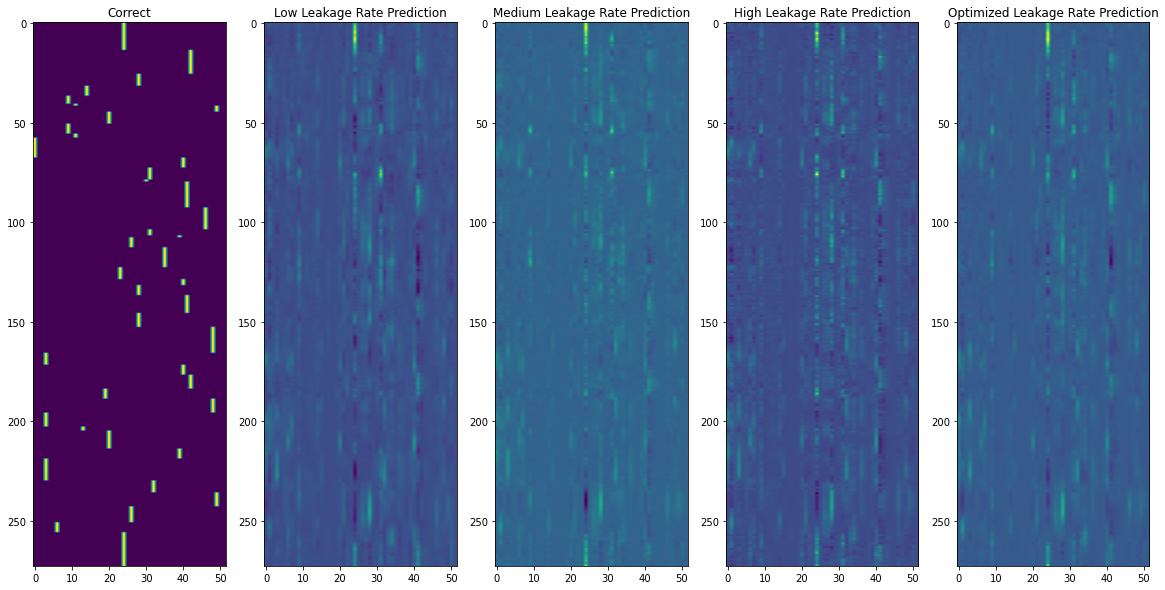

In [65]:
pred_low = sub_systems_low[0].run(test_data[0])
pred_medium = sub_systems_medium[0].run(test_data[0])
pred_high = sub_systems_high[0].run(test_data[0])
pred_opt = sub_systems_opt[0].run(test_data[0])

fig, ax = plt.subplots(1, 5, figsize=(20, 10))
ax[0].imshow(test_target1[0].T, aspect='auto')
ax[1].imshow(pred_low, aspect='auto')
ax[2].imshow(pred_medium, aspect='auto')
ax[3].imshow(pred_high, aspect='auto')
ax[4].imshow(pred_opt, aspect='auto')
ax[0].set_title("Correct")
ax[1].set_title("Low Leakage Rate Prediction")
ax[2].set_title("Medium Leakage Rate Prediction")
ax[3].set_title("High Leakage Rate Prediction")
ax[4].set_title("Optimized Leakage Rate Prediction")


mse_low = mse(pred_low, test_target1[0].T)
print(mse_low)
mse_medium = mse(pred_medium, test_target1[0].T)
print(mse_medium)
mse_high = mse(pred_high, test_target1[0].T)
print(mse_high)
mse_opt = mse(pred_opt, test_target1[0].T)
print(mse_opt)

Running Model-27: 273it [00:00, 3578.18it/s]                                                                           
Running Model-33: 273it [00:00, 4475.23it/s]                                                                           
Running Model-39: 273it [00:00, 3899.99it/s]                                                                           
Running Model-9: 273it [00:00, 4475.19it/s]                                                                            


0.01634110468570337
0.018400388797768265
0.019894028845503203
0.018501224048019484


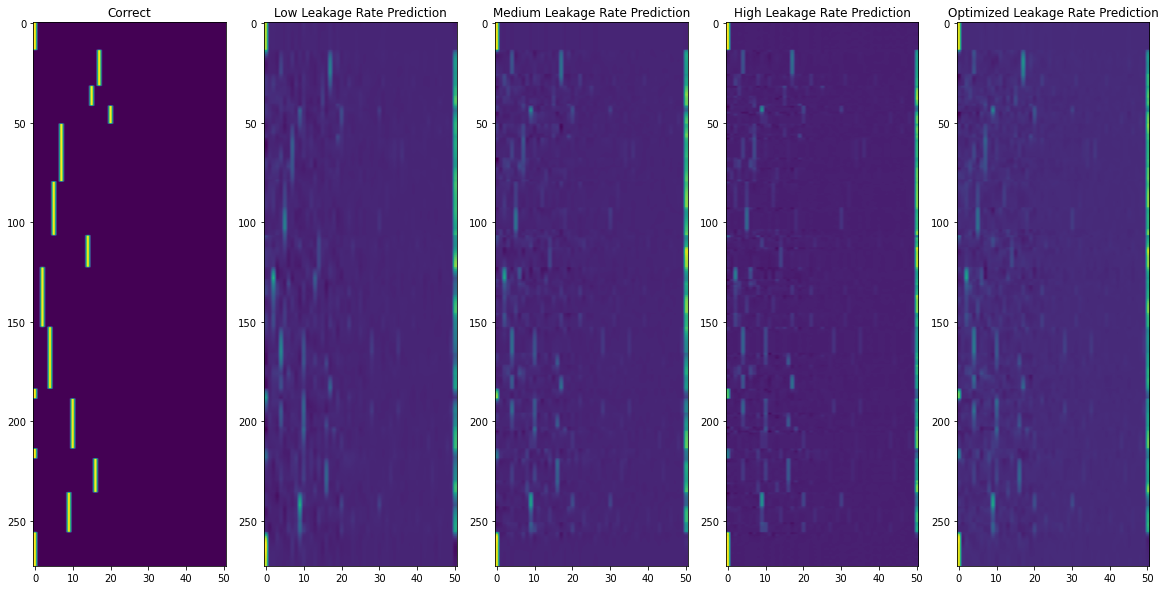

In [66]:
pred_low = sub_systems_low[1].run(test_target1[0].T)
pred_medium = sub_systems_medium[1].run(test_target1[0].T)
pred_high = sub_systems_high[1].run(test_target1[0].T)
pred_opt = sub_systems_opt[1].run(test_target1[0].T)

fig, ax = plt.subplots(1, 5, figsize=(20, 10))
ax[0].imshow(test_target2[0].T, aspect='auto')
ax[1].imshow(pred_low, aspect='auto')
ax[2].imshow(pred_medium, aspect='auto')
ax[3].imshow(pred_high, aspect='auto')
ax[4].imshow(pred_opt, aspect='auto')
ax[0].set_title("Correct")
ax[1].set_title("Low Leakage Rate Prediction")
ax[2].set_title("Medium Leakage Rate Prediction")
ax[3].set_title("High Leakage Rate Prediction")
ax[4].set_title("Optimized Leakage Rate Prediction")


mse_low = mse(pred_low, test_target2[0].T)
print(mse_low)
mse_medium = mse(pred_medium, test_target2[0].T)
print(mse_medium)
mse_high = mse(pred_high, test_target2[0].T)
print(mse_high)
mse_opt = mse(pred_opt, test_target2[0].T)
print(mse_opt)

Running Model-29: 273it [00:00, 4432.44it/s]                                                                           
Running Model-35: 273it [00:00, 4706.64it/s]                                                                           
Running Model-41: 273it [00:00, 4496.01it/s]                                                                           
Running Model-11: 273it [00:00, 4014.77it/s]                                                                           


0.0030806882128912596
0.0008919835279215621
0.00021648403925533373
0.00022012219804852103


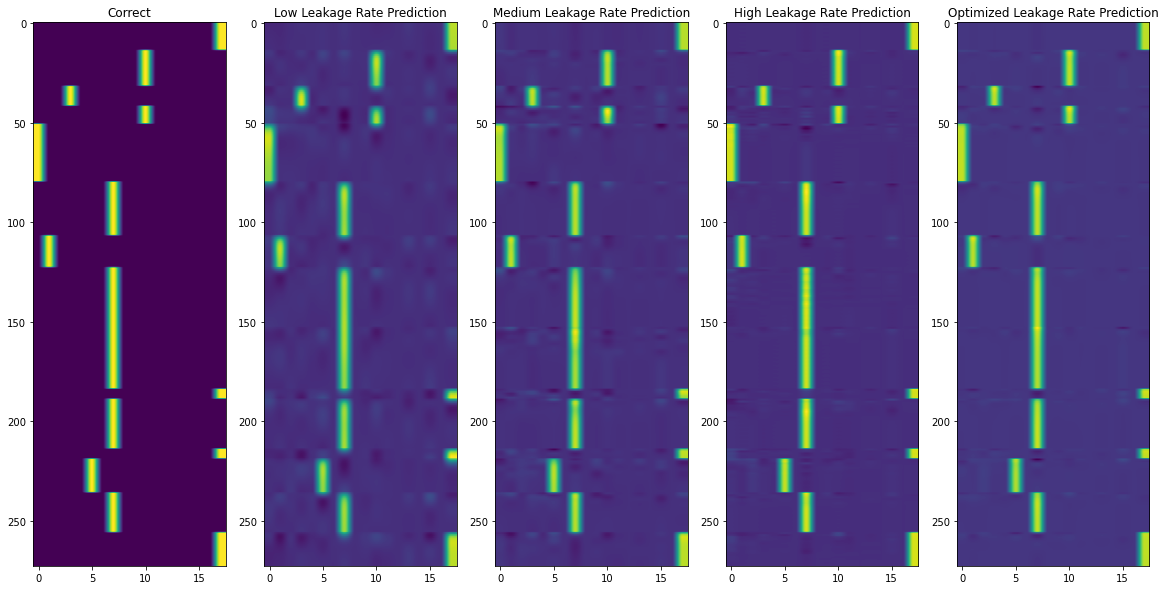

In [67]:
pred_low = sub_systems_low[2].run(test_target2[0].T)
pred_medium = sub_systems_medium[2].run(test_target2[0].T)
pred_high = sub_systems_high[2].run(test_target2[0].T)
pred_opt = sub_systems_opt[2].run(test_target2[0].T)

fig, ax = plt.subplots(1, 5, figsize=(20, 10))
ax[0].imshow(test_target3[0].T, aspect='auto')
ax[1].imshow(pred_low, aspect='auto')
ax[2].imshow(pred_medium, aspect='auto')
ax[3].imshow(pred_high, aspect='auto')
ax[4].imshow(pred_opt, aspect='auto')
ax[0].set_title("Correct")
ax[1].set_title("Low Leakage Rate Prediction")
ax[2].set_title("Medium Leakage Rate Prediction")
ax[3].set_title("High Leakage Rate Prediction")
ax[4].set_title("Optimized Leakage Rate Prediction")


mse_low = mse(pred_low, test_target3[0].T)
print(mse_low)
mse_medium = mse(pred_medium, test_target3[0].T)
print(mse_medium)
mse_high = mse(pred_high, test_target3[0].T)
print(mse_high)
mse_opt = mse(pred_opt, test_target3[0].T)
print(mse_opt)

Mean temporal ratio (phonemes / input): 7.292230856727217 ms


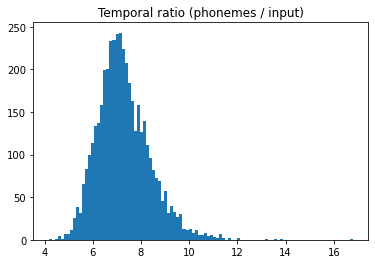

In [24]:
ratios = []
for ph, wd in zip(train_data, train_target1):
    ph_duration = np.mean(np.diff(np.nonzero(np.diff(np.argmax(ph, axis=0)))[0]))
    wd_duration = np.mean(np.diff(np.nonzero(np.diff(np.argmax(wd, axis=0)))[0]))
    ratios.append(wd_duration / ph_duration)

plt.hist(ratios, 100)
plt.title("Temporal ratio (phonemes / input)")
print("Mean temporal ratio (phonemes / input): {} ms".format(np.mean(ratios)))

Mean temporal ratio (words / phonemes): 6.779254416271836 ms


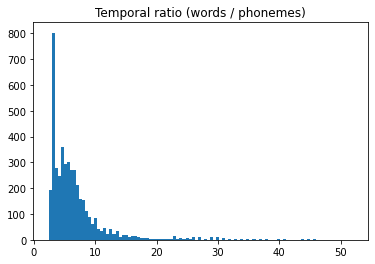

In [25]:
ratios = []
for ph, wd in zip(train_target1, train_target2):
    ph_duration = np.mean(np.diff(np.nonzero(np.diff(np.argmax(ph, axis=0)))[0]))
    wd_duration = np.mean(np.diff(np.nonzero(np.diff(np.argmax(wd, axis=0)))[0]))
    ratios.append(wd_duration / ph_duration)

plt.hist(ratios, 100)
plt.title("Temporal ratio (words / phonemes)")
print("Mean temporal ratio (words / phonemes): {} ms".format(np.mean(ratios)))

Mean temporal ratio (POS / words): 0.7789491893918294 ms


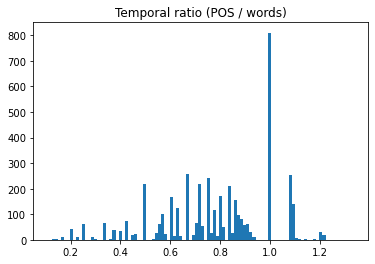

In [26]:
ratios = []
for wd, pos in zip(train_target2, train_target3):
    wd_duration = np.mean(np.diff(np.nonzero(np.diff(np.argmax(wd, axis=0)))[0]))
    pos_duration = np.mean(np.diff(np.nonzero(np.diff(np.argmax(pos, axis=0)))[0]))
    ratios.append(pos_duration / wd_duration)
    
plt.hist(ratios, 100)
plt.title("Temporal ratio (POS / words)")
print("Mean temporal ratio (POS / words): {} ms".format(np.mean(ratios)))